In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
from __future__ import print_function

import datetime
import pandas as pd
import numpy as np
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from utils.kerasutil import *
from utils import scenariob
from utils import scenarioc
from FintechCapstone import FinCapstone

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pd.options.display.max_rows = 30


In [186]:
%matplotlib inline

plt.style.use('seaborn-whitegrid')

date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

trial = FinCapstone(model_name="FullScenarioC", scenario="scenarioc",ticker_list_samplesize=4, timespan=timespan, date_from=date_from, reset_status=False)
#trial = FinCapstone(ticker_list=["ZHNE","BSFT","AERO","MATR","ITMSF","FIT","TIPT","OLBK","QADA","ATTU","LGF","STX","TPCS","GSAT","ZNGA","GLW","HIMX","YHOO", "NWSA","JAKK","GLUU","AMZN", "AAPL", "EBAY", "GOOG", "NFLX", "DIS", "EA", "TWTR", "FB", "TTWO", "PXLW", "UBI"], scenario="scenarioa", ticker_list_samplesize=4, timespan=timespan, date_from=date_from, reset_status=False)
#trial = FinCapstone(encode_workpages=10,model_name="FullScenarioC", scenario="scenarioc", ticker_list_samplesize=200, timespan=timespan, date_from=date_from, reset_status=False)

#trial.run_initial_dataload()
#trial.feature_engineering()
#trial.feature_encoding()

nasdaq100 has 107 tickers.


Final dataset has 107 records
(OK) Final dataset has 107 distinct tickers


In [207]:
_r = pd.DataFrame()
for itr_ticker in trial.valid_ticker_list():
    itr_frame = load_raw_frame(itr_ticker)
    itr_frame["Ticker"] = itr_ticker
    _r = pd.concat([_r, itr_frame], axis=0)

_r.fillna(0, inplace=True)
_r.describe().T.to_csv("report_resources/features_describe.csv")
_r.describe().T


,count,mean,std,min,25%,50%,75%,max
Open,274829.0,1.224650e+02,3.719208e+02,-1.0,22.85,38.33,76.35,6.450000e+03
High,274829.0,1.239115e+02,3.766637e+02,-1.0,23.12,38.75,77.00,6.500000e+03
Low,274829.0,1.207062e+02,3.666199e+02,-1.0,22.47,37.80,75.26,6.375000e+03
Close,274829.0,1.228089e+02,3.718391e+02,-1.0,22.99,38.44,76.71,6.500000e+03
Volume,274829.0,1.001917e+07,2.588597e+07,0.0,1359616.00,3097155.00,8149152.00,1.785686e+09


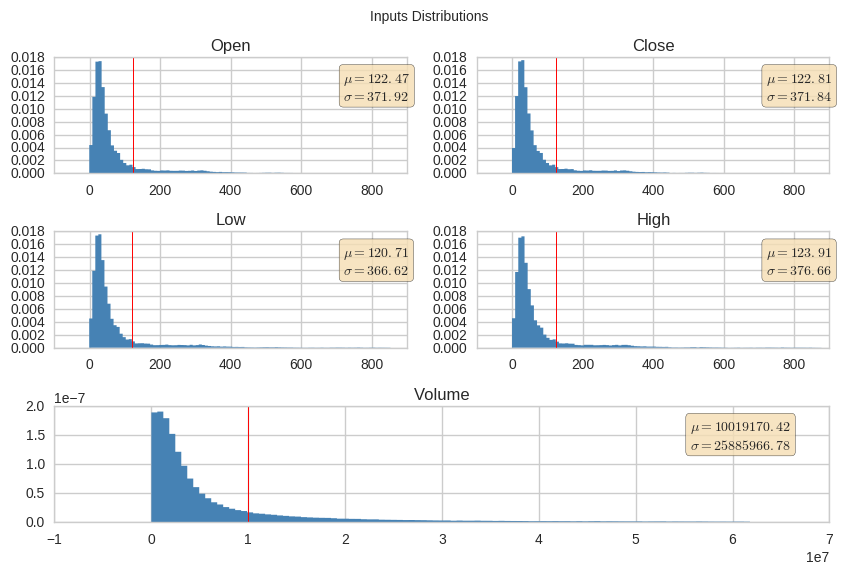

In [200]:

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(3, 2, hspace=0.5, wspace=0.2)


cols = ["Open", "Close", "Low", "High", "Volume"]
axes = [None] * 5

axes[0] = fig.add_subplot(grid[0,0])
axes[1] = fig.add_subplot(grid[0,1])
axes[2] = fig.add_subplot(grid[1,0])
axes[3] = fig.add_subplot(grid[1,1])
axes[4] = fig.add_subplot(grid[2,:])

for idx, itr_col in enumerate(cols):
    _range = [-10.0, _r[itr_col].mean() + (2 * _r[itr_col].std())]
    axes[idx].set_title(itr_col)
    axes[idx].hist(_r[itr_col], bins=100, histtype='stepfilled', color='steelblue', edgecolor='none', normed=True, range=_range)
    axes[idx].axvline(_r[itr_col].mean(),color="red", linewidth=0.7)
    
    textstr = '$\mu=%.2f$\n$\sigma=%.2f$'%(_r[itr_col].mean(), _r[itr_col].std())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    # place a text box in upper left in axes coords
    axes[idx].text(0.82, 0.9, textstr, transform=axes[idx].transAxes, fontsize=10,
            verticalalignment='top' ,bbox=props)


plt.suptitle('Inputs Distributions')

plt.savefig("report_resources/input_dist.svg", format="svg")
plt.savefig("report_resources/input_dist.png", format="png")
plt.show()

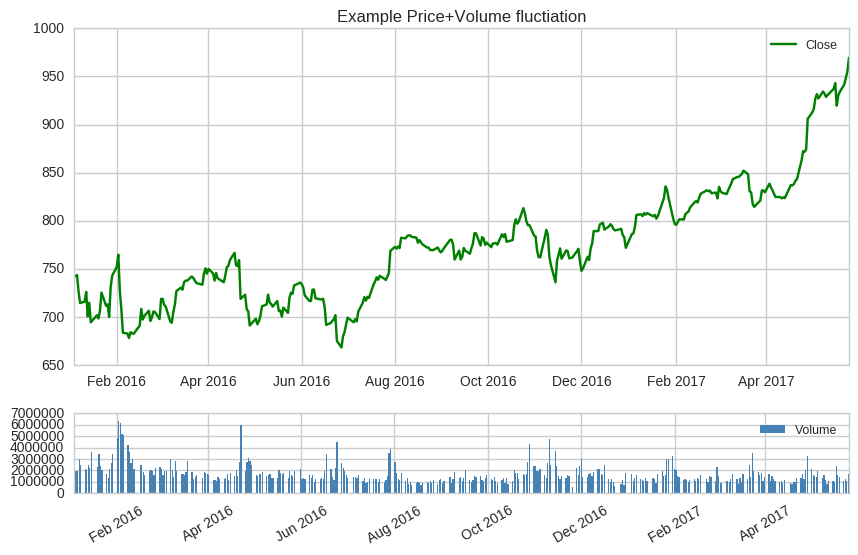

In [201]:
example_df = _r[(_r["Ticker"] == "GOOG") & (_r["Date"] > '2016-01-01')]
# get our x ticks
x = example_df["Date"].values

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=0.2)

volume_hist = fig.add_subplot(grid[-1:,:])
main_ax = fig.add_subplot(grid[:-1, :], sharex=None)

main_ax.set_title("Example Price+Volume fluctiation")

#Main Plot
main_ax.plot(x, example_df["Close"], '-g', label="Close")


#Volume Plot
volume_hist.bar(x, example_df["Volume"], label="Volume", color='steelblue', edgecolor='none')

#setting legends
main_ax.legend(prop={'size':9})
volume_hist.legend(prop={'size':9})


# rotating ticks
for tick in volume_hist.get_xticklabels():
    tick.set_rotation(30)

plt.savefig("report_resources/ticker_example.svg", format="svg")
plt.savefig("report_resources/ticker_example.png", format="png")
plt.show()

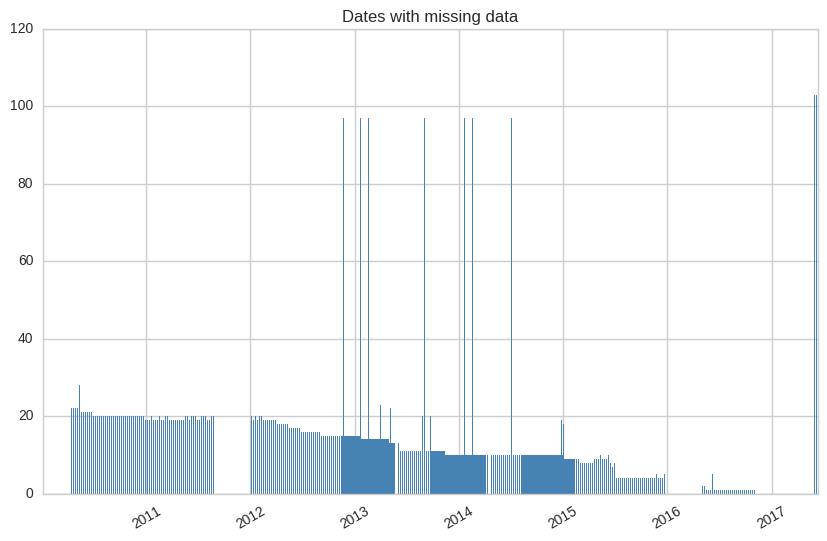

In [202]:
missing_data = _r["Date"].value_counts().max() - _r["Date"].value_counts()
missing_data = missing_data[missing_data.index > pd.to_datetime("2010-01-01")]

x = missing_data.index.tolist()

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(1, 4, hspace=0.6, wspace=0.2)

volume_hist = fig.add_subplot(grid[0,:])

volume_hist.set_title("Dates with missing data")

#Volume Plot
volume_hist.bar(x, missing_data, color='steelblue', edgecolor='none')

# rotating ticks
for tick in volume_hist.get_xticklabels():
    tick.set_rotation(30)

plt.savefig("report_resources/missing_data.svg", format="svg")
plt.savefig("report_resources/missing_data.png", format="png")
plt.show()

In [204]:
_r = pd.DataFrame()
for itr_ticker in trial.valid_ticker_list():
    itr_frame = trial.load_scenarioc_labels(itr_ticker)
    itr_frame["Ticker"] = itr_ticker
    _r = pd.concat([_r, itr_frame], axis=0)

_r.fillna(0, inplace=True)
_r.describe().T.to_csv("report_resources/labels_describe.csv")
_r.describe().T

,count,mean,std,min,25%,50%,75%,max
RETURN_1,195628.0,0.001435,0.223854,-0.904255,-0.008839,0.000541,0.010337,98.523810
RETURN_30,195628.0,0.028102,0.224104,-0.923200,-0.033976,0.021306,0.082634,84.238095
RETURN_60,195628.0,0.056395,0.263157,-0.923810,-0.032166,0.042982,0.131159,87.285714
RETURN_200,195628.0,0.172534,0.434187,-0.942029,0.000000,0.101449,0.291627,81.000000


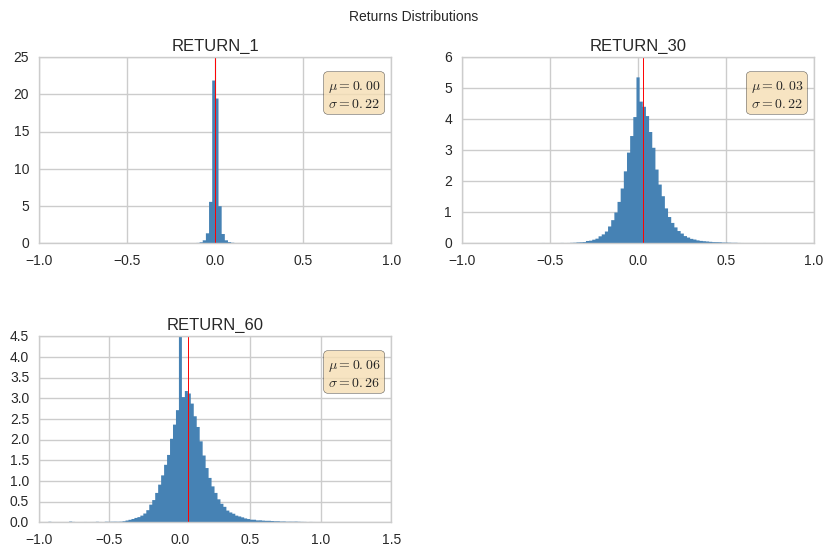

In [205]:

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.2)


cols = ["RETURN_1", "RETURN_30", "RETURN_60"]
axes = [None] * 4

axes[0] = fig.add_subplot(grid[0,0])
axes[1] = fig.add_subplot(grid[0,1])
axes[2] = fig.add_subplot(grid[1,0])


for idx, itr_col in enumerate(cols):
    _range = [_r[itr_col].mean() - (4 * _r[itr_col].std()), _r[itr_col].mean() + (4 * _r[itr_col].std())]
    axes[idx].set_title(itr_col)
    axes[idx].hist(_r[itr_col], bins=100, histtype='stepfilled', color='steelblue', edgecolor='none', normed=True, range=_range)
    #sns.distplot(_r[itr_col], bins=100, ax=axes[idx], norm_hist=True)
    axes[idx].axvline(_r[itr_col].mean(),color="red", linewidth=0.7)
    
    textstr = '$\mu=%.2f$\n$\sigma=%.2f$'%(_r[itr_col].mean(), _r[itr_col].std())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    # place a text box in upper left in axes coords
    axes[idx].text(0.82, 0.9, textstr, transform=axes[idx].transAxes, fontsize=10,
            verticalalignment='top' ,bbox=props)


plt.suptitle('Returns Distributions')

plt.savefig("report_resources/returns_dist.svg", format="svg")
plt.savefig("report_resources/returns_dist.png", format="png")
plt.show()


/home/pedro/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


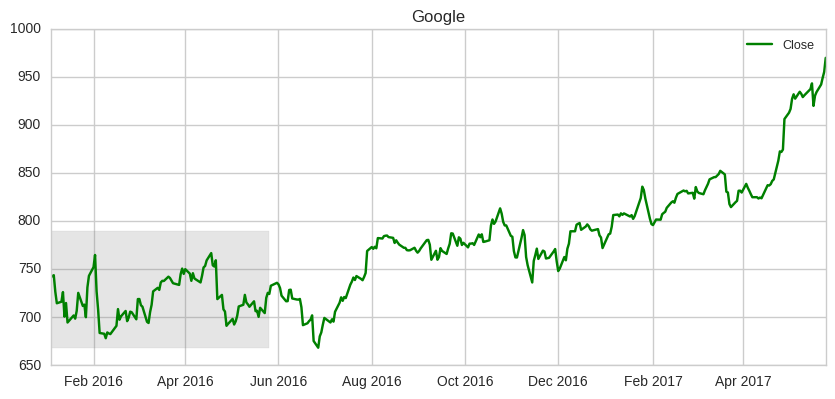

In [203]:
n_quant = 10

example_df = _r[(_r["Ticker"] == "GOOG") & (_r["Date"] > '2016-01-01')]
# get our x ticks
x = example_df["Date"].values

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=0.2)

main_ax = fig.add_subplot(grid[:-1, :], sharex=None)

main_ax.set_title("Google")

#Main Plot
main_ax.plot(x, example_df["Close"], '-g', label="Close")


_min = np.min(example_df["Close"])
_max = np.max(example_df["Close"])

plt.axvspan(x[0], x[100], 0.05, 0.4,color="grey", alpha=0.2)




#setting legends
main_ax.legend(prop={'size':9})
volume_hist.legend(prop={'size':9})


# rotating ticks
for tick in volume_hist.get_xticklabels():
    tick.set_rotation(30)

plt.savefig("report_resources/ticker_quantized.svg", format="svg")
plt.savefig("report_resources/ticker_quantized.png", format="png")
plt.show()

/home/pedro/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


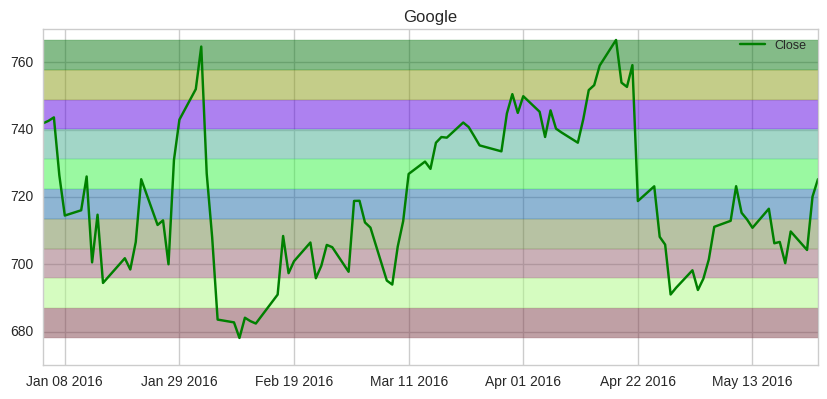

In [208]:
n_quant = 10

example_df = _r[(_r["Ticker"] == "GOOG") & (_r["Date"] > '2016-01-01')]
# get our x ticks
x = example_df["Date"].values[0:100]
y = example_df["Close"].iloc[0:100]

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=0.2)

main_ax = fig.add_subplot(grid[:-1, :], sharex=None)

main_ax.set_title("Google")

#Main Plot
main_ax.plot(x, y, '-g', label="Close")


_min = np.min(y)
_max = np.max(y)

for itr in range(n_quant):
    y0 = ((1/n_quant) * itr) * (_max - _min) + _min
    y1 = (min(1, (1/n_quant) * (itr + 1))) * (_max - _min) + _min
    plt.axhspan(y0, y1, color=np.random.rand(3,1), alpha=0.5)




#setting legends
main_ax.legend(prop={'size':9})
volume_hist.legend(prop={'size':9})


# rotating ticks
for tick in volume_hist.get_xticklabels():
    tick.set_rotation(30)

plt.savefig("report_resources/ticker_quantized.svg", format="svg")
plt.savefig("report_resources/ticker_quantized.png", format="png")
plt.show()

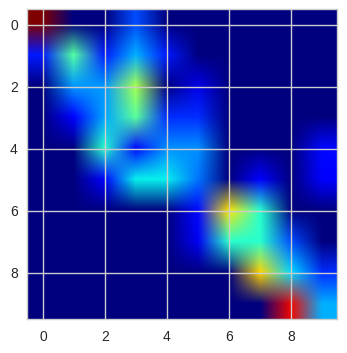

In [209]:
def markov_transition_matrix(serie, n_states):
    ## Digitize the column and create the "next state" by shifting it
    states = pd.DataFrame()
    states["state_in"] = np.digitize(serie, np.linspace(serie.min(), serie.max(), n_states, False))
    states["state_out"] = states["state_in"].shift(-1).values.astype(np.int)
    states["pair_count"] = 1
    states = states.iloc[:-1] ## because of the shift, the last row will have a Nan converted to int, which is garbage
    
    ## create the total count of obervations in each state
    states_count = states.loc[:,["state_in", "state_out"]].groupby(["state_in"]).count()
    
    ## groupby to get the count of state_in/state_out pairs
    states = states.groupby(["state_in", "state_out"]).count()
    
    ## Pivot it to create our
    states.reset_index(level=["state_in", "state_out"], inplace=True)
    states = states.pivot("state_in", "state_out").fillna(0)

    ## get the frequency 
    states = states / states_count.values.flatten()
    
    ## drop the dummy variable just so our output look nicer
    states.columns = states.columns.droplevel(0)
    
    
    ## we might need to force the indexes if some states don't really happen
    _full_state = np.arange(0,n_states) + 1
    
    return pd.DataFrame(states.T, index=_full_state, columns=_full_state).fillna(0)


states = markov_transition_matrix(y, n_quant)

plt.imshow(states, cmap="jet")
plt.imsave("report_resources/mtm.svg", states, format="svg", cmap="jet")
plt.imsave("report_resources/mtm.png", states, format="png", cmap="jet")
plt.show()

W = states

W.to_csv("report_resources/mtm.csv", index=True)

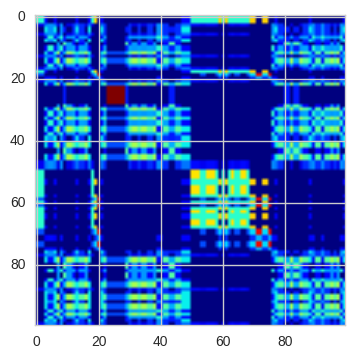

In [210]:
def markov_transition_field(serie, n_states):
    W = markov_transition_matrix(serie, n_states)
    
    ## this will be the "state_in"
    i = pd.DataFrame(np.digitize(serie, np.linspace(serie.min(), serie.max(), n_states, False))).T
    i = i.append([i] * (serie.shape[0] - 1), ignore_index=True)
    
    # this will be the "state_out"
    j = i.T
    
    ## stack i and j depth-wise (create pairs that go from the i-th state to the j-th state)
    M = np.dstack((i, j))
    
    ## find each pair probability on W
    M = np.apply_along_axis(lambda ij_pair: W.loc[ij_pair[0],ij_pair[1]], 2, M)
    
    # now we actually have "M"
    M = pd.DataFrame(M)
    
    return M

M = markov_transition_field(y, n_quant)

plt.imshow(M, cmap="jet")
plt.imsave("report_resources/mtf.svg", M, format="svg", cmap="jet")
plt.imsave("report_resources/mtf.png", M, format="png", cmap="jet")
plt.show()

M.to_csv("report_resources/mtf.csv", index=True)

In [40]:
_r = pd.DataFrame()
for itr_ticker in trial.valid_ticker_list():
    itr_frame = trial.load_scenarioc_features(itr_ticker)
    itr_frame["Ticker"] = itr_ticker
    _r = pd.concat([_r, itr_frame], axis=0)

_r.fillna(0, inplace=True)
_r.describe().T.to_csv("report_resources/featurescalc_describe.csv")
_r.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,195586.0,1.205566e+02,2.674244e+02,2.100000e-01,2.743000e+01,4.576000e+01,8.943000e+01,3.500000e+03
RSI_60,195586.0,5.267639e+01,6.038934e+00,2.489819e+01,4.874050e+01,5.277457e+01,5.673217e+01,8.727029e+01
OBV,195586.0,3.792710e+08,1.007311e+09,-4.236286e+09,2.458925e+07,1.302955e+08,3.663640e+08,1.095782e+10


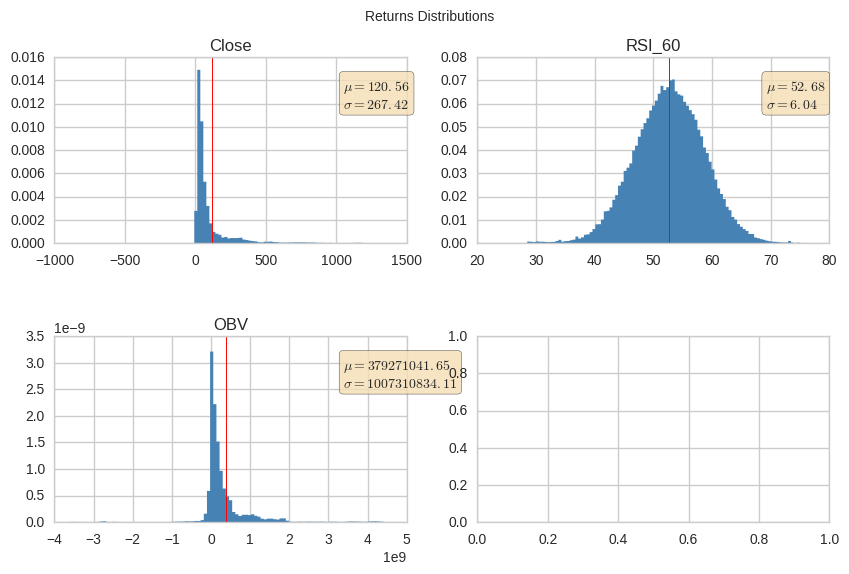

In [41]:

# setup figure
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.2)


cols = ["Close", "RSI_60", "OBV"]
axes = [None] * 4

axes[0] = fig.add_subplot(grid[0,0])
axes[1] = fig.add_subplot(grid[0,1])
axes[2] = fig.add_subplot(grid[1,0])
axes[3] = fig.add_subplot(grid[1,1])

for idx, itr_col in enumerate(cols):
    _range = [_r[itr_col].mean() - (4 * _r[itr_col].std()), _r[itr_col].mean() + (4 * _r[itr_col].std())]
    axes[idx].set_title(itr_col)
    axes[idx].hist(_r[itr_col], bins=100, histtype='stepfilled', color='steelblue', edgecolor='none', normed=True, range=_range)
    #sns.distplot(_r[itr_col], bins=100, ax=axes[idx], norm_hist=True)
    axes[idx].axvline(_r[itr_col].mean(),color="red", linewidth=0.7)
    
    textstr = '$\mu=%.2f$\n$\sigma=%.2f$'%(_r[itr_col].mean(), _r[itr_col].std())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    # place a text box in upper left in axes coords
    axes[idx].text(0.82, 0.9, textstr, transform=axes[idx].transAxes, fontsize=10,
            verticalalignment='top' ,bbox=props)


plt.suptitle('Returns Distributions')

plt.savefig("report_resources/returns_dist.svg", format="svg")
plt.savefig("report_resources/returns_dist.png", format="png")
plt.show()


# We are changing for ExampleFintech now. With ScenarioB

In [196]:
trialB = FinCapstone(scenario="scenariob",ticker_list_samplesize=1000, timespan=timespan, date_from=date_from, reset_status=False)

#trialB.run_initial_dataload()
#trialB.feature_engineering()
#trialB.feature_encoding()

nasdaq100 has 107 tickers.


Final dataset has 107 records
(OK) Final dataset has 107 distinct tickers


In [197]:
_r = pd.DataFrame()
for itr_ticker in trialB.valid_ticker_list():
    itr_frame = trialB.load_scenariob_features(itr_ticker)
    itr_frame["Ticker"] = itr_ticker
    _r = pd.concat([_r, itr_frame], axis=0, ignore_index=True)

_r.fillna(0, inplace=True)
#_r.describe().T.to_csv("report_resources/featurescalc_describe.csv")
_r.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,195904.0,1.206321e+02,2.674242e+02,2.100000e-01,27.450000,4.580000e+01,8.955000e+01,3.500000e+03
SMA_5,195904.0,9.970325e-01,5.863785e-02,0.000000e+00,0.987621,9.984300e-01,1.009490e+00,8.663556e+00
SMA_30,195904.0,9.779898e-01,1.610643e-01,0.000000e+00,0.956476,9.876965e-01,1.021271e+00,1.048954e+01
SMA_60,195904.0,9.548507e-01,2.285120e-01,0.000000e+00,0.929632,9.744027e-01,1.022952e+00,1.087134e+01
SMA_200,195904.0,8.604998e-01,4.046260e-01,0.000000e+00,0.832653,9.210251e-01,1.008576e+00,1.342679e+01
BOLL_5_UP,195904.0,1.029971e+00,9.601210e-02,0.000000e+00,1.010512,1.020443e+00,1.039175e+00,1.723371e+01
BOLL_5_DOWN,195904.0,9.640940e-01,6.271649e-02,-5.546374e+00,0.956367,9.762431e-01,9.878846e-01,1.000000e+00
...,...,...,...,...,...,...,...,...
ADX_PDI,195904.0,6.742165e-01,1.633705e-01,0.000000e+00,0.573104,6.900136e-01,7.934929e-01,1.000000e+00
ADX_NDI,195904.0,6.718471e-01,1.789900e-01,0.000000e+00,0.555853,6.812027e-01,8.021441e-01,1.000000e+00


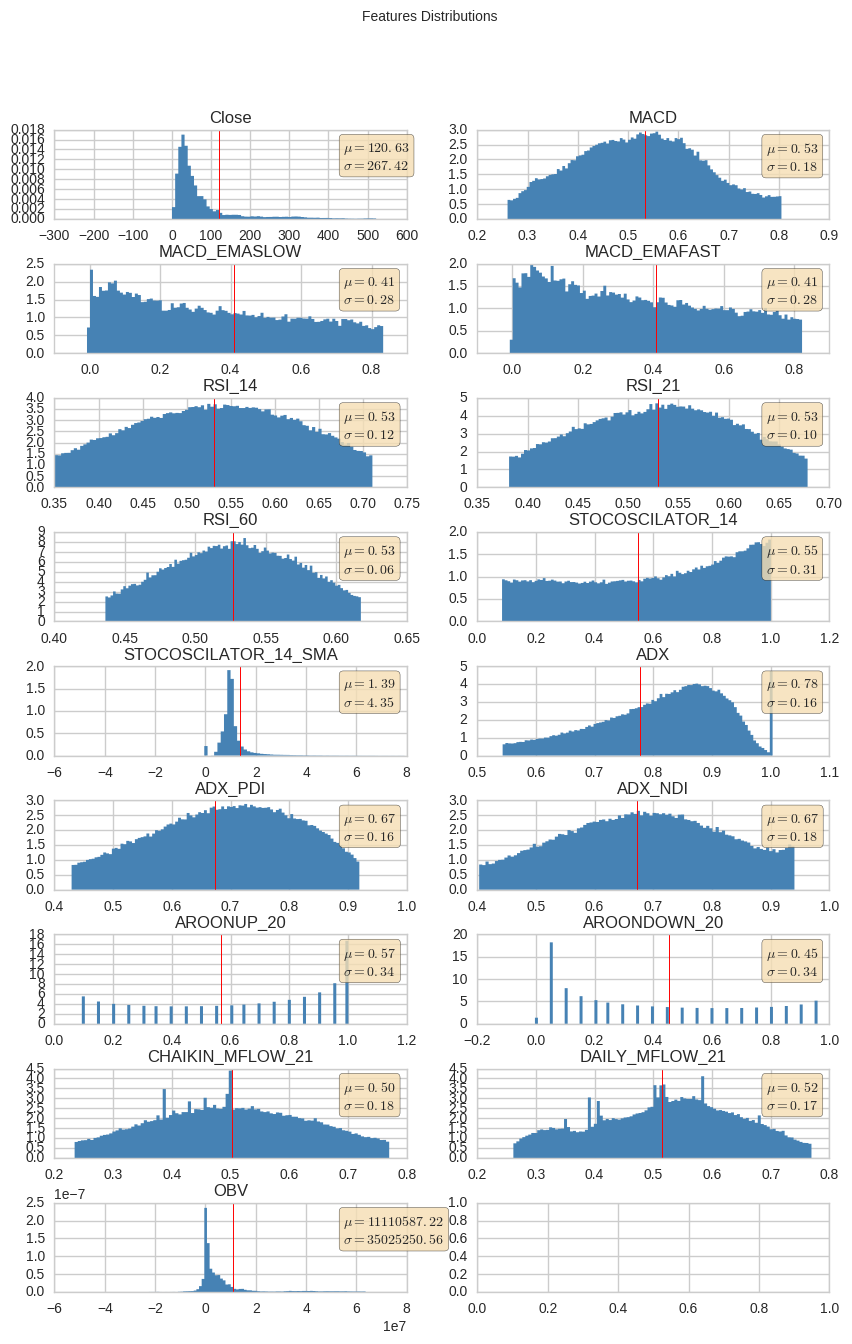

In [199]:

# setup figure
fig = plt.figure(figsize=(10, 15))
grid = plt.GridSpec(9, 2, hspace=0.5, wspace=0.2)


cols = [ 'Close', 'MACD', 'MACD_EMASLOW', 'MACD_EMAFAST', 'RSI_14', 'RSI_21',
 'RSI_60', 'STOCOSCILATOR_14', 'STOCOSCILATOR_14_SMA', 'ADX', 'ADX_PDI', 'ADX_NDI',
 'AROONUP_20', 'AROONDOWN_20', 'CHAIKIN_MFLOW_21', 'DAILY_MFLOW_21', 'OBV']
axes = [None] * 29

axes[0] = fig.add_subplot(grid[0, 0])
axes[1] = fig.add_subplot(grid[0, 1])

axes[2] = fig.add_subplot(grid[1, 0])
axes[3] = fig.add_subplot(grid[1, 1])

axes[4] = fig.add_subplot(grid[2, 0])
axes[5] = fig.add_subplot(grid[2, 1])

axes[6] = fig.add_subplot(grid[3, 0])
axes[7] = fig.add_subplot(grid[3, 1])

axes[8] = fig.add_subplot(grid[4, 0])
axes[9] = fig.add_subplot(grid[4, 1])

axes[10] = fig.add_subplot(grid[5, 0])
axes[11] = fig.add_subplot(grid[5, 1])

axes[12] = fig.add_subplot(grid[6, 0])
axes[13] = fig.add_subplot(grid[6, 1])

axes[14] = fig.add_subplot(grid[7, 0])
axes[15] = fig.add_subplot(grid[7, 1])

axes[16] = fig.add_subplot(grid[8, 0])
axes[17] = fig.add_subplot(grid[8, 1])






for idx, itr_col in enumerate(cols):
    _range = [_r[itr_col].mean() - (1.5 * _r[itr_col].std()), _r[itr_col].mean() + (1.5 * _r[itr_col].std())]
    axes[idx].set_title(itr_col)
    axes[idx].hist(_r[itr_col], bins=100, histtype='stepfilled', color='steelblue', edgecolor='none', normed=True, range=_range)
    #sns.distplot(_r[itr_col], bins=100, ax=axes[idx], norm_hist=True)
    axes[idx].axvline(_r[itr_col].mean(),color="red", linewidth=0.7)
    
    textstr = '$\mu=%.2f$\n$\sigma=%.2f$'%(_r[itr_col].mean(), _r[itr_col].std())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    # place a text box in upper left in axes coords
    axes[idx].text(0.82, 0.9, textstr, transform=axes[idx].transAxes, fontsize=10,
            verticalalignment='top' ,bbox=props)


plt.suptitle('Features Distributions')

plt.savefig("report_resources/features_dist.svg", format="svg")
plt.savefig("report_resources/features_dist.png", format="png")
plt.show()


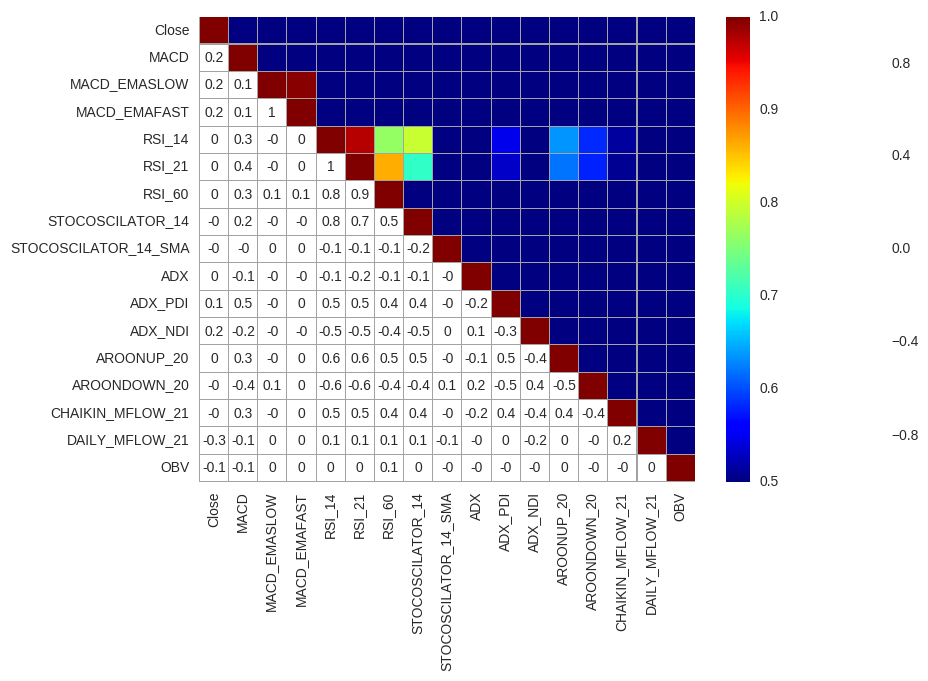

In [200]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10,6))

corr = _r.loc[:, cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(np.around(corr, 1), mask=mask, xticklabels=cols, annot=True, ax=ax, cmap=ListedColormap(['white']))
sns.heatmap(np.abs(corr), mask=~mask, xticklabels=cols, vmin=0.5, annot=False, ax=ax, cmap="jet", linewidths=0.05, linecolor="#a3a3a3")

plt.savefig("report_resources/features_corr.svg", format="svg")
plt.savefig("report_resources/features_corr.png", format="png")
plt.show()

In [220]:
samples = np.arange(1,21)
samples = (0.7531 * samples)
samples = samples[:-2]
samples

array([  0.7531,   1.5062,   2.2593,   3.0124,   3.7655,   4.5186,
         5.2717,   6.0248,   6.7779,   7.531 ,   8.2841,   9.0372,
         9.7903,  10.5434,  11.2965,  12.0496,  12.8027,  13.5558])

In [225]:
_r = []
for s in samples:
    _df = pd.read_csv("FullScenarioC_%s_eval_status.tmp" % s)
    _df["start"] = pd.to_datetime(_df["start"])
    _df["end"] = pd.to_datetime(_df["end"])

    _df = _df.iloc[:_df["start"].argmax()]

    _r.append([s
                ,_df.loc[_df["mse_test"].argmin(), "epochs"]
                ,_df.loc[_df["mse_test"].argmin(), "mse"]
                ,_df.loc[_df["mse_test"].argmin(), "mse_test"]
                ,_df.loc[_df["mse_test"].argmin(), "r_squared"]
                ,_df.loc[_df["mse_test"].argmin(), "r_squared_test"]
                ,_df.loc[_df["mse_test"].argmin(), "accuracy"]
                ,_df.loc[_df["mse_test"].argmin(), "accuracy_test"]])
    
_r = pd.DataFrame(_r, columns=["sample_size", "epochs","mse", "mse_test", "r_squared", "r_squared_test", "accuracy", "accuracy_test"])

#_r["sample_size"] = [10, 20, 30, 40, 50, 60]
_r



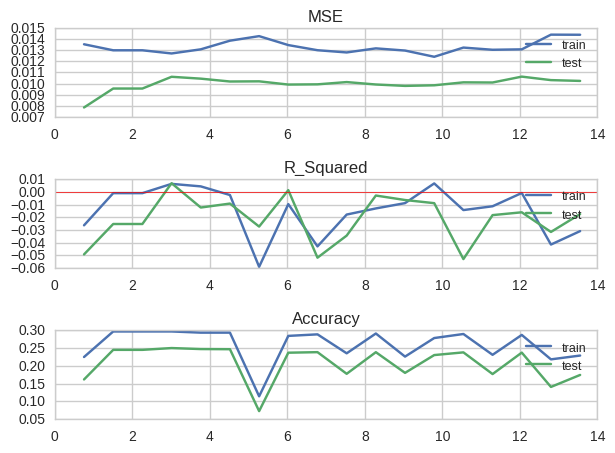

In [222]:
fig = plt.figure(figsize=(7, 7))
grid = plt.GridSpec(4, 4, hspace=0.7, wspace=0.2)

ax = fig.add_subplot(grid[0,:])
ax2 = fig.add_subplot(grid[1,:])
ax3 = fig.add_subplot(grid[2,:])


ax.set_title("MSE")
ax.plot(_r["sample_size"], _r["mse"], label="train")
ax.plot(_r["sample_size"], _r["mse_test"], label="test")

ax2.set_title("R_Squared")
ax2.plot(_r["sample_size"], _r["r_squared"], label="train")
ax2.plot(_r["sample_size"], _r["r_squared_test"], label="test")
ax2.axhline(0, linewidth=0.5, color="r")

ax3.set_title("Accuracy")
ax3.plot(_r["sample_size"], _r["accuracy"], label="train")
ax3.plot(_r["sample_size"], _r["accuracy_test"], label="test")



ax.legend(prop={'size':9})
ax2.legend(prop={'size':9})
ax3.legend(prop={'size':9})

plt.savefig("report_resources/evaluation.svg", format="svg")
plt.savefig("report_resources/evaluation.png", format="png")

plt.show()


In [138]:
_df = pd.read_csv("FullScenarioC_20_train_status.tmp")
_df.iloc[5:]

,ticker,epochs,status,start,end,msg,loss
5,GOOGL,0,NOK,2017-06-14 07:39:30.042034,2017-06-14 07:39:51.710244,Dst tensor is not initialized.\n\t [[Node: Con...,NaN
6,AMZN,0,NOK,2017-06-14 07:46:07.328790,2017-06-14 07:46:33.316909,Dst tensor is not initialized.\n\t [[Node: Con...,NaN
7,AAL,2000,OK,2017-06-14 07:47:53.205946,2017-06-14 08:39:39.682695,NaN,NaN
8,AMGN,0,INCOMPLETE,NaN,NaN,NaN,NaN
9,ADI,0,INCOMPLETE,NaN,NaN,NaN,NaN
10,AAPL,0,INCOMPLETE,NaN,NaN,NaN,NaN
11,AMAT,0,INCOMPLETE,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
100,VIAB,0,INCOMPLETE,NaN,NaN,NaN,NaN
101,VOD,0,INCOMPLETE,NaN,NaN,NaN,NaN


In [147]:
from IPython.display import FileLinks
FileLinks('report_resources/', included_suffixes=[".png"], recursive=False)

report_resources/
  evaluation.png
  features_dist.png
  mtf.png
  missing_data.png
  mtm.png
  ticker_quantized.png
  ticker_example.png
  input_dist.png
  features_corr.png
  returns_dist.png

In [146]:
from IPython.display import FileLinks
FileLinks('report_resources/', included_suffixes=[".svg"], recursive=False)

report_resources/
  ticker_quantized.svg
  features_dist.svg
  returns_dist.svg
  mtf.svg
  ticker_example.svg
  features_corr.svg
  mtm.svg
  missing_data.svg
  input_dist.svg
  evaluation.svg

In [226]:
FileLinks('report_resources/', included_suffixes=[".csv"], recursive=False)

report_resources/
  mtf.csv
  mtm.csv
  labels_describe.csv
  features_describe.csv
  GOOG_sample.csv
  featurescalc_describe.csv

In [228]:
FileLinks('.',included_suffixes=[".csv"], recursive=False)

./
  RES_initial_dataload.csv
  features_describe.csv
  inputs_describe.csv
  GOOG_sample.csv
  evals.csv